In [1]:
from yfinance import Ticker, download
import pandas as pd
import numpy as np
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fft import fft, fftfreq, ifft
import numpy, scipy.optimize
from sklearn.preprocessing import minmax_scale
import pylab as plt

## Loading Crypto Data and Extract df of Close prices

In [2]:
avail_cryptos = pd.read_excel("yf-crypto-tickers.xlsx").set_index("Unnamed: 0")["Tickers"]
df_close = pd.DataFrame()

for i in range(len(avail_cryptos)):
    df = Ticker(avail_cryptos[i]).history(period="1y")["Close"].rename(avail_cryptos[i])
    df_close = pd.concat([df_close, df], axis=1)
    
df_close = df_close.dropna(axis=1)

- BUSD2-USD: No data found, symbol may be delisted
- BUSD1-USD: No data found, symbol may be delisted
- EUR2-USD: No data found, symbol may be delisted
- TRY1-USD: No data found, symbol may be delisted


In [4]:
avail_cryptos[0]

'SHIB-USD'

In [3]:
def get_crypto_df(ticker):
    df = Ticker(ticker).history(period="1y")["Close"].rename(ticker)
    return df

# Example of a lagged rolling correlation between BTC and ETH

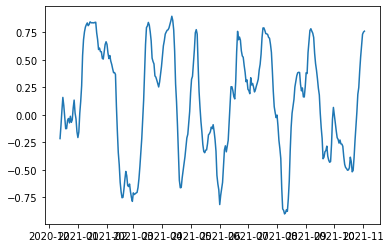

In [4]:
def lag_roll_corr(series1, series2, lag):
    """
    Inputs:
    - series1: series 1 who's current day values have their rolling correlation taken with series2's future lagged values - the hypothethical independent variable
    - series2: the series which has it's future values correlated with series1's past values - the hypothetical dependent variable
    Outputs:
    - lagged rolling correlation with series 1 current day values correlated with series 2 future lagged values
    """
    pair = pd.concat([series1, series2], axis=1)
    pair.iloc[:, 0] = pair.iloc[:, 0].shift(lag)
    lagged_rcorr = pair.iloc[:, 0].rolling(lag).corr(pair.iloc[:, 1])
    lagged_rcorr = lagged_rcorr.dropna()
    return lagged_rcorr

def lag_roll_kendall(series1, series2, lag):
    """
    Inputs:
    - series1: series 1 who's current day values have their rolling kendall tau taken with series2's future lagged values - the hypothethical independent variable
    - series2: the series which has it's future values correlated with series1's past values - the hypothetical dependent variable
    Outputs:
    - lagged rolling correlation with series 1 current day values rank correlated (kendall tau) with series 2 future lagged values
    """
    ken_values = []
    series2 = series2.shift(-lag).dropna()
    
    for i in range(0, len(series2)-lag+1):
        ken_values.append(kendalltau(series1[0+i:lag+i], series2[0+i:lag+i])[0])

    return pd.DataFrame(ken_values).set_index(series1.index[lag-1:len(btc)-lag])

def lag_roll_spearman(series1, series2, lag):
    """
    Inputs:
    - series1: series 1 who's current day values have their rolling kendall tau taken with series2's future lagged values - the hypothethical independent variable
    - series2: the series which has it's future values correlated with series1's past values - the hypothetical dependent variable
    Outputs:
    - lagged rolling correlation with series 1 current day values rank correlated (spearman r) with series 2 future lagged values
    """
    ken_values = []
    series2 = series2.shift(-lag).dropna()
    
    for i in range(0, len(series2)-lag+1):
        ken_values.append(spearmanr(series1[0+i:lag+i], series2[0+i:lag+i])[0])

    return pd.DataFrame(ken_values).set_index(series1.index[lag-1:len(btc)-lag])


# example of how to run the functions
lag = 21
btc = df_close.iloc[:, 0]
eth = df_close.iloc[:, 1]
lag_rollktau = lag_roll_kendall(btc, eth, lag)
lag_roll_spearr = lag_roll_spearman(btc, eth, lag)
lag_roll_pears = lag_roll_corr(btc, eth, lag)

plt.plot(lag_roll_pears)

COTI-USD


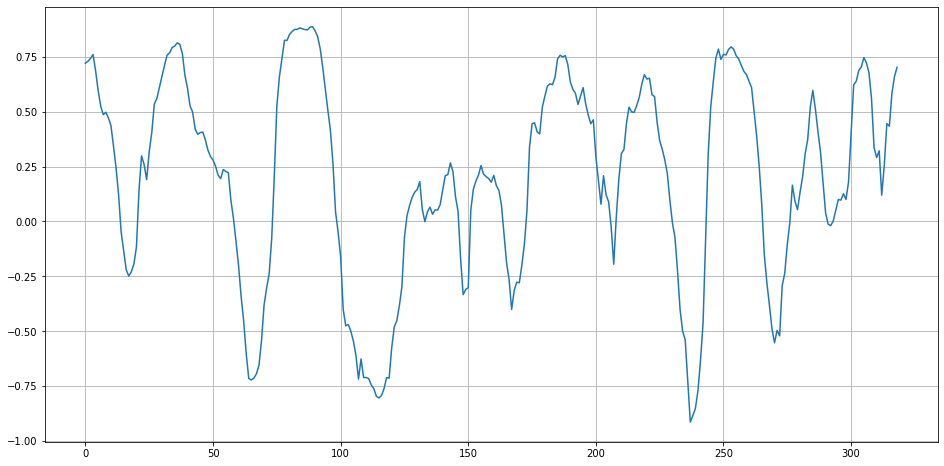

In [57]:
lag = 24
btc = df_close.iloc[:, 0]
dependent_var = df_close.iloc[:, 25]

print(dependent_var.name)

lag_roll_pears = lag_roll_corr(btc, dependent_var, lag)

plt.figure(figsize=(16,8))
plt.plot(np.arange(0, len(lag_roll_pears), 1), lag_roll_pears) # plotting lagged rolling pearson correlation
plt.grid()
plt.show()

# Fitting a sinewave to the data

In [6]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess, maxfev=5000)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

Amplitude=-0.31192024595933426, Angular freq.=0.1154361088864605, phase=0.7621016756449427, offset=0.19440978577945167, Max. Cov.=0.04460872247798758


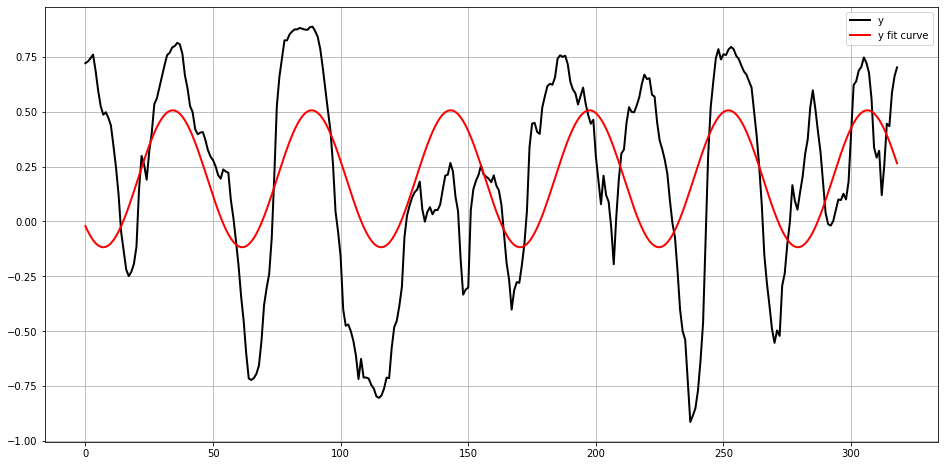

In [7]:
plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

## Error Functions between Sine and Original

In [8]:
# MSE
mse = sum((lag_roll_pears.values - res["fitfunc"](tt))**2)

# MAE
mae = sum(abs(lag_roll_pears.values - res["fitfunc"](tt)))


## Putting it all together and finding the lags that correspond closest to a period sine wave

In [9]:
btc = df_close.iloc[:, 0]
dependent_var = df_close.iloc[:, 2]

output = []

for lag in range(2, 45):
    
    #print(lag)

    # obtaining the correlations
    lag_roll_pears = lag_roll_corr(btc, dependent_var, lag)

    # generating the sinewave
    tt = np.arange(0, len(lag_roll_pears), 1)
    res = fit_sin(tt, lag_roll_pears)

    # error functions
    mse = sum((lag_roll_pears.values - res["fitfunc"](tt))**2)
    mae = sum(abs(lag_roll_pears.values - res["fitfunc"](tt)))
    period = int((2*np.pi)/res["omega"])
    output.append([lag, mse, mae, period, btc.name, dependent_var.name])
    
display(output)

[[2, 349.73994549814194, 349.739947813859, 5, 'BTC-USD', 'DOGE-USD'],
 [3, 176.96821432320664, 224.72759768723105, 16, 'BTC-USD', 'DOGE-USD'],
 [4, 140.392196735253, 195.89369352834157, 20, 'BTC-USD', 'DOGE-USD'],
 [5, 103.69836097614765, 162.80538256647648, 17, 'BTC-USD', 'DOGE-USD'],
 [6, 94.768807807542, 158.65972216184215, 38, 'BTC-USD', 'DOGE-USD'],
 [7, 92.3104559415689, 152.59675121084507, 38, 'BTC-USD', 'DOGE-USD'],
 [8, 87.59188291095192, 150.46363222673867, 70, 'BTC-USD', 'DOGE-USD'],
 [9, 73.279961799784, 137.85947283806456, 71, 'BTC-USD', 'DOGE-USD'],
 [10, 67.77492767996495, 131.8083333298343, 37, 'BTC-USD', 'DOGE-USD'],
 [11, 68.9640988105881, 132.14389274216234, 37, 'BTC-USD', 'DOGE-USD'],
 [12, 66.36797661230489, 126.51392730434196, 329, 'BTC-USD', 'DOGE-USD'],
 [13, 70.47582676722116, 130.86833208056288, 337, 'BTC-USD', 'DOGE-USD'],
 [14, 73.39651564167032, 134.2592513293645, 37, 'BTC-USD', 'DOGE-USD'],
 [15, 62.10207121146123, 121.34923233613101, 37, 'BTC-USD', 'DOGE-

### Getting IDX of minimum MSEs or MAEs

In [10]:
mses = pd.DataFrame(output)[1].values
maes = pd.DataFrame(output)[2].values

k = 3

top_lags = pd.DataFrame(output)
columns = ["Lags", "MSE", "MAE", "Periodicity", "Independent Var", "Dependent Var"]
top_lags.columns = columns
top_lags = top_lags[top_lags["Periodicity"] < 100] # periodicity filter
top_lags.nsmallest(k, "MSE")

,Lags,MSE,MAE,Periodicity,Independent Var,Dependent Var
19,21,44.980622,102.041097,33,BTC-USD,DOGE-USD
20,22,45.869123,102.390239,33,BTC-USD,DOGE-USD
42,44,48.827581,97.523561,89,BTC-USD,DOGE-USD


In [11]:
mses = pd.DataFrame(output)[1].values
maes = pd.DataFrame(output)[2].values

k = 3

top_lags = pd.DataFrame(output)
columns = ["Lags", "MSE", "MAE", "Periodicity", "Independent Var", "Dependent Var"]
top_lags.columns = columns

display(top_lags)
top_lags = top_lags[top_lags["Periodicity"] < 100] # periodicity filter

idx = np.argpartition(top_lags["MSE"].values, k) # getting best fits 

top_lags = top_lags.loc[idx[:k]] # keeping top 'k' optimal fits

top_lags

,Lags,MSE,MAE,Periodicity,Independent Var,Dependent Var
0,2,349.739945,349.739948,5,BTC-USD,DOGE-USD
1,3,176.968214,224.727598,16,BTC-USD,DOGE-USD
2,4,140.392197,195.893694,20,BTC-USD,DOGE-USD
3,5,103.698361,162.805383,17,BTC-USD,DOGE-USD
4,6,94.768808,158.659722,38,BTC-USD,DOGE-USD
5,7,92.310456,152.596751,38,BTC-USD,DOGE-USD
6,8,87.591883,150.463632,70,BTC-USD,DOGE-USD
7,9,73.279962,137.859473,71,BTC-USD,DOGE-USD
8,10,67.774928,131.808333,37,BTC-USD,DOGE-USD
9,11,68.964099,132.143893,37,BTC-USD,DOGE-USD


,Lags,MSE,MAE,Periodicity,Independent Var,Dependent Var
18,20,55.190564,112.739139,33,BTC-USD,DOGE-USD
17,19,65.448350,123.176376,33,BTC-USD,DOGE-USD
21,23,49.950246,108.339518,33,BTC-USD,DOGE-USD


# Hypothesis Testing
# Experiment 1: Running function with BTC and ETH as predictors and finding most periodic correlations

### Function to return top lags

In [12]:
def return_top_lags(predictor, predictee, k):

    output = []

    for lag in range(2, 30):

        #print(lag)

        # obtaining the correlations
        lag_roll_pears = lag_roll_corr(predictor, predictee, lag)

        # generating the sinewave
        tt = np.arange(0, len(lag_roll_pears), 1)
        res = fit_sin(tt, lag_roll_pears)

        # error functions
        mse = sum((lag_roll_pears.values - res["fitfunc"](tt))**2)
        mae = sum(abs(lag_roll_pears.values - res["fitfunc"](tt)))
        period = int((2*np.pi)/res["omega"])
        output.append([lag, mse, mae, period, predictor.name, predictee.name])
        
        
    mses = pd.DataFrame(output)[1].values # getting MSEs in df

    top_lags = pd.DataFrame(output) # put all values into dataframe

    columns = ["Lags", "MSE", "MAE", "Periodicity", "Independent Var", "Dependent Var"] # column names
    
    top_lags.columns = columns # set col names

    top_lags = top_lags[top_lags["Periodicity"] < 100] # periodicity filter

    top_lags = top_lags.nsmallest(k, "MSE")
    
    return top_lags

In [13]:
k = 3

per_hy_df = pd.DataFrame()

for j in range(0, 2):

    predictor = df_close.iloc[:, j] 
    
    for i in range(1, len(df_close.columns)-1):
        dependent_var = df_close.iloc[:, i]
        tmp_df = return_top_lags(predictor, dependent_var, k)
        per_hy_df = pd.concat([per_hy_df, tmp_df], axis=0)
    
per_hy_df = per_hy_df.sort_values(by="MSE")

per_hy_df = per_hy_df.reset_index(drop=True)

per_hy_df

,Lags,MSE,MAE,Periodicity,Independent Var,Dependent Var
0,27,13.527184,51.237634,52,ETH-USD,USDT-USD
1,26,15.679678,58.031833,52,ETH-USD,USDT-USD
2,19,19.862961,65.426070,33,ETH-USD,USDT-USD
3,18,20.737006,67.950520,67,BTC-USD,USDT-USD
4,26,20.784768,66.015156,65,BTC-USD,USDT-USD
...,...,...,...,...,...,...
157,20,63.994845,123.752478,41,ETH-USD,DOGE-USD
158,17,64.089149,119.372482,36,ETH-USD,VET-USD
159,8,72.777620,136.542202,24,ETH-USD,THETA-USD
160,12,72.791767,130.554147,66,ETH-USD,THETA-USD


### Plotting the most period lagged correlation

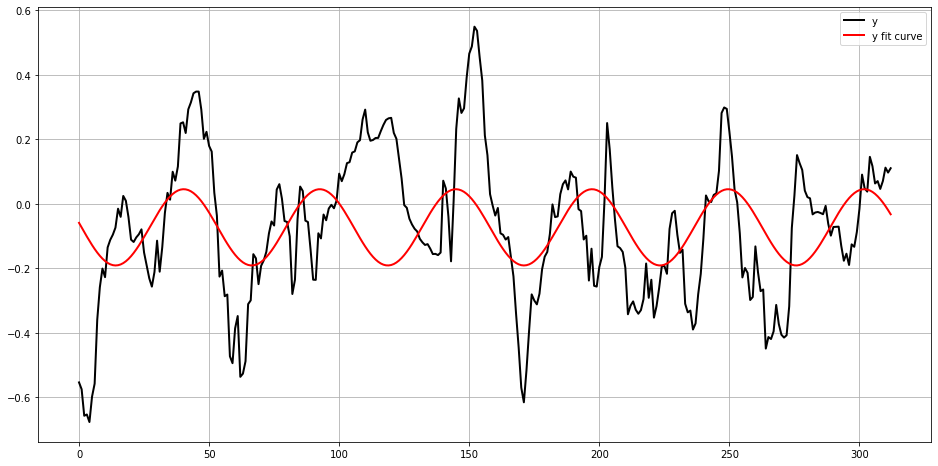

Independent Variable:  ETH-USD - Dependent Variable:  USDT-USD


In [14]:
lags = per_hy_df.iloc[0]["Lags"]

indep = df_close[per_hy_df.iloc[0]["Independent Var"]]

dep = df_close[per_hy_df.iloc[0]["Dependent Var"]]

lag_roll_pears = lag_roll_corr(indep, dep, lags)

# generating the sinewave
tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)

plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

print("Independent Variable: ", per_hy_df.iloc[0]["Independent Var"], "-", "Dependent Variable: ", per_hy_df.iloc[0]["Dependent Var"])

# Experiment 2: Finding lagged correlations with greatest % of values > threshold

### Function to return assets with largest % of lagged correlations greater than threshold value

In [15]:
def return_top_perc(predictor, predictee, k, thresh, lag_range):
    
    output = []
    
    for lag in range(lag_range[0], lag_range[1]):
        lag_roll_pears = lag_roll_corr(predictor, predictee, lag)
        perc = len(lag_roll_pears[abs(lag_roll_pears) > thresh])/len(lag_roll_pears)
        tt = np.arange(0, len(lag_roll_pears), 1)
        res = fit_sin(tt, lag_roll_pears)
        period = int((2*np.pi)/res["omega"])
        output.append([lag, perc, period, predictor.name, predictee.name])
        
    top_perc = pd.DataFrame(output)
    
    columns = ["Lags", "Percentage > {}".format(thresh), "Periodicity", "Independent Var", "Dependent Var"] # column names
    
    top_perc.columns = columns # set col names
    
    top_perc = top_perc[top_perc["Periodicity"] < 100] # periodicity filter
    
    top_perc = top_perc.nlargest(k, "Percentage > {}".format(thresh))
                                  
    return top_perc

In [16]:
thresh = 0.7
k = 3
lag_range = [5, 30]
high_corr = pd.DataFrame()

for j in range(0, 2):

    predictor = df_close.iloc[:, j] 
    
    for i in range(2, len(df_close.columns)-1):
        dependent_var = df_close.iloc[:, i]
        tmp_df = return_top_perc(predictor, dependent_var, k, thresh, lag_range)
        high_corr = pd.concat([high_corr, tmp_df], axis=0)
        
high_corr = high_corr.sort_values(by= "Percentage > {}".format(thresh), ascending=False)

high_corr = high_corr.reset_index(drop=True)

high_corr

,Lags,Percentage > 0.7,Periodicity,Independent Var,Dependent Var
0,20,0.357798,55,BTC-USD,AVAX-USD
1,11,0.356522,48,ETH-USD,EGLD-USD
2,5,0.355742,87,BTC-USD,XLM-USD
3,5,0.352941,88,BTC-USD,LTC-USD
4,5,0.350140,19,ETH-USD,SOL1-USD
...,...,...,...,...,...
151,5,0.218487,44,BTC-USD,USDT-USD
152,6,0.160563,20,BTC-USD,USDT-USD
153,6,0.154930,19,ETH-USD,USDT-USD
154,10,0.112392,63,ETH-USD,USDT-USD


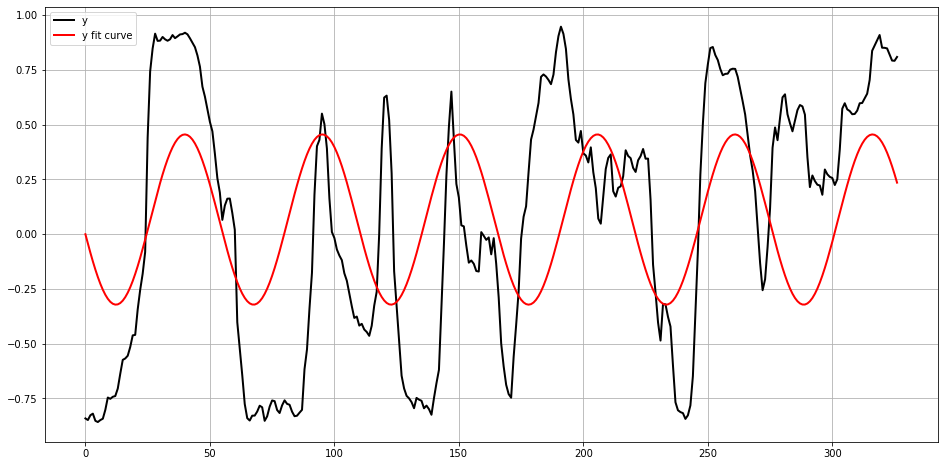

Independent Variable:  BTC-USD - Dependent Variable:  AVAX-USD


In [17]:
which_lag = 0

lags = high_corr.iloc[which_lag]["Lags"]

indep = df_close[high_corr.iloc[which_lag]["Independent Var"]]

dep = df_close[high_corr.iloc[which_lag]["Dependent Var"]]

lag_roll_pears = lag_roll_corr(indep, dep, lags)

# generating the sinewave
tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)

plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

print("Independent Variable: ", high_corr.iloc[0]["Independent Var"], "-", "Dependent Variable: ", high_corr.iloc[0]["Dependent Var"])

# Experiment 3: Finding the most accurate directional lagged correlations predicted by sinusoids
- take sign of differenced of the lagged correlations
- take sign of difference of fitted sine waves
- obtain percentage of correctly predicted values

In [18]:
def return_top_dir_lag(predictor, predictee, k):

    output = []

    for lag in range(2, 45):

        #print(lag)

        # obtaining the correlations
        lag_roll_pears = lag_roll_corr(predictor, predictee, lag)

        # generating the sinewave
        tt = np.arange(0, len(lag_roll_pears), 1)
        res = fit_sin(tt, lag_roll_pears)

        corr_diff_sign = np.sign(lag_roll_pears.diff().dropna())

        sine_diff_sign = np.sign(np.diff(res["fitfunc"](tt)))

        tmp = corr_diff_sign - sine_diff_sign

        sign_accuracy = len(tmp[tmp==0])/len(tmp)

        period = int((2*np.pi)/res["omega"])

        output.append([lag, sign_accuracy, period, predictor.name, predictee.name])


    mses = pd.DataFrame(output)[1].values # getting MSEs in df

    top_lags = pd.DataFrame(output) # put all values into dataframe

    columns = ["Lags", "Accuracy", "Periodicity", "Independent Var", "Dependent Var"] # column names

    top_lags.columns = columns # set col names

    top_lags = top_lags[top_lags["Periodicity"] < 100] # periodicity filter

    top_lags = top_lags.nlargest(k, "Accuracy")

    return top_lags

In [19]:
thresh = 0.7
k = 3

top_dir_lags = pd.DataFrame()

for j in range(0, 2):

    predictor = df_close.iloc[:, j] 
    
    for i in range(2, len(df_close.columns)-1):
        dependent_var = df_close.iloc[:, i]
        tmp_df = return_top_dir_lag(predictor, dependent_var, k)
        top_dir_lags = pd.concat([top_dir_lags, tmp_df], axis=0)
        
top_dir_lags = top_dir_lags.sort_values(by= "Accuracy", ascending=False)

top_dir_lags = top_dir_lags.reset_index(drop=True)

top_dir_lags

,Lags,Accuracy,Periodicity,Independent Var,Dependent Var
0,26,0.770701,34,BTC-USD,BNB-USD
1,29,0.769481,34,BTC-USD,BNB-USD
2,28,0.764516,34,BTC-USD,BNB-USD
3,37,0.753425,60,ETH-USD,BCH-USD
4,34,0.751678,61,ETH-USD,BCH-USD
...,...,...,...,...,...
151,16,0.592814,56,BTC-USD,ETC-USD
152,15,0.592262,43,ETH-USD,THETA-USD
153,23,0.590625,79,BTC-USD,BCH-USD
154,24,0.588050,62,ETH-USD,LUNA1-USD


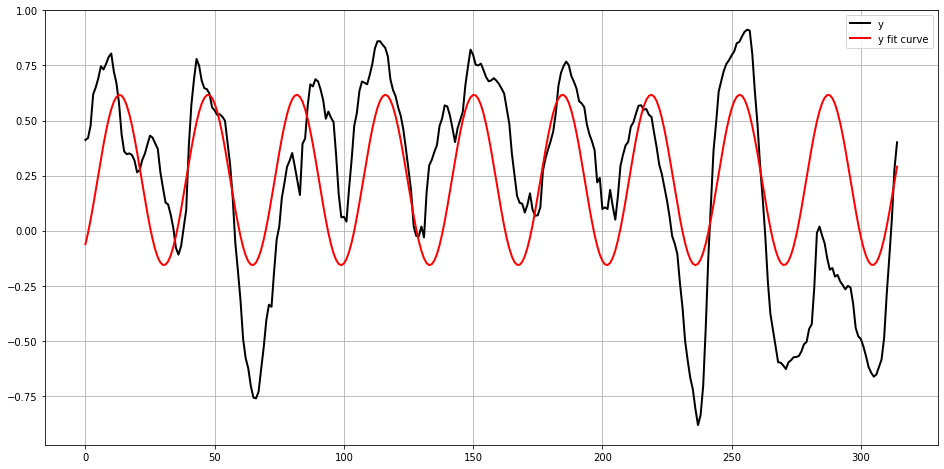

Independent Variable:  BTC-USD - Dependent Variable:  BNB-USD - Lags:  26


In [20]:
which_lag = 0

lags = top_dir_lags.iloc[which_lag]["Lags"]

indep = df_close[top_dir_lags.iloc[which_lag]["Independent Var"]]

dep = df_close[top_dir_lags.iloc[which_lag]["Dependent Var"]]

lag_roll_pears = lag_roll_corr(indep, dep, lags)

# generating the sinewave
tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)

plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

print("Independent Variable: ", top_dir_lags.iloc[which_lag]["Independent Var"], "-", "Dependent Variable: ", top_dir_lags.iloc[which_lag]["Dependent Var"], "-", "Lags: ", lags)

# Now we are going to look at market variables during the lagged correlation periods

## Market variable analysis

- We will look at it from the perspective of the market data during the period pertaining to the independent variable
- We will call the independent variable, I, the dependent variable, D, and the lag, N
- We want to know what is happening in the market data of I whenever it produces a point correlation with D for the next N days
- Hence, we implicitly include a look ahead/ forward bias of N days because those N days would be required to obtain the point correlation
- Note: this analysis is purely investigatory and the plots themselves are not directly alpha generative in any shape or form
- The idea is to understand what market variables of I are doing to produce future correlations with D 
- An example conclusion we hope to derive from this analysis is 
    - "Market variable X tends to have a statistically higher mean during periods that I produces a stronger future correlation in D"
- We would go about showing this by plotting the rolling lagged point correlation plot alongside the market variables beginning at time t=N-:
    - This time point represents the time for the first series of I to be loaded in to apply a point correlation with the next N days of D
    - However, in real time we would not have this point correlation as aforementioned due to the requirement of needing the next N days of D 

In [21]:
# top directinal lagged signal
which_lag = 0
lags = top_dir_lags.iloc[which_lag]["Lags"]
indep = df_close[top_dir_lags.iloc[which_lag]["Independent Var"]]
dep = df_close[top_dir_lags.iloc[which_lag]["Dependent Var"]]
lag_roll_pears = lag_roll_corr(indep, dep, lags)
trading_idx = lag_roll_pears.index
idx_of_interest = indep[lags-1:-lags].index

# building a dataframe containing returns, rolling std, and volume of both variables at idx of interest
# independent variable
df_indep = Ticker(indep.name).history(period="1y")
df_indep["Returns"] = df_indep["Close"].pct_change()
df_indep["1WkVol"] = df_indep["Returns"].rolling(7).std()

# dependent variable
df_dep = Ticker(dep.name).history(period="1y")
df_dep["Returns"] = df_dep["Close"].pct_change()
df_dep["1WkVol"] = df_dep["Returns"].rolling(7).std()

df_indep = df_indep[["Close", "Returns", "1WkVol", "Volume"]]
df_dep = df_dep[["Close", "Returns", "1WkVol", "Volume"]]

df_indep.columns = ["Independent " + col for col in df_indep.columns]
df_dep.columns = ["Dependent " + col for col in df_dep.columns]

analysis_df = pd.concat([df_indep, df_dep], axis=1)

analysis_df = analysis_df.loc[idx_of_interest]
lag_roll_pears.index = idx_of_interest

analysis_df = pd.concat([analysis_df, lag_roll_pears], axis=1)
analysis_df = analysis_df.rename(columns={0: "Correlation"})
analysis_df["CorrDiff"] = np.sign(analysis_df["Correlation"].diff())
analysis_df = analysis_df.dropna()

# Looking at the two time series having their rolling lagged correlation taken in real time 

## Note
- The events from the independent variable at each time point in this plot occur "lags" #days before the events of the dependent variable
- The dependent variable plotted here is a lag number of days shifted back

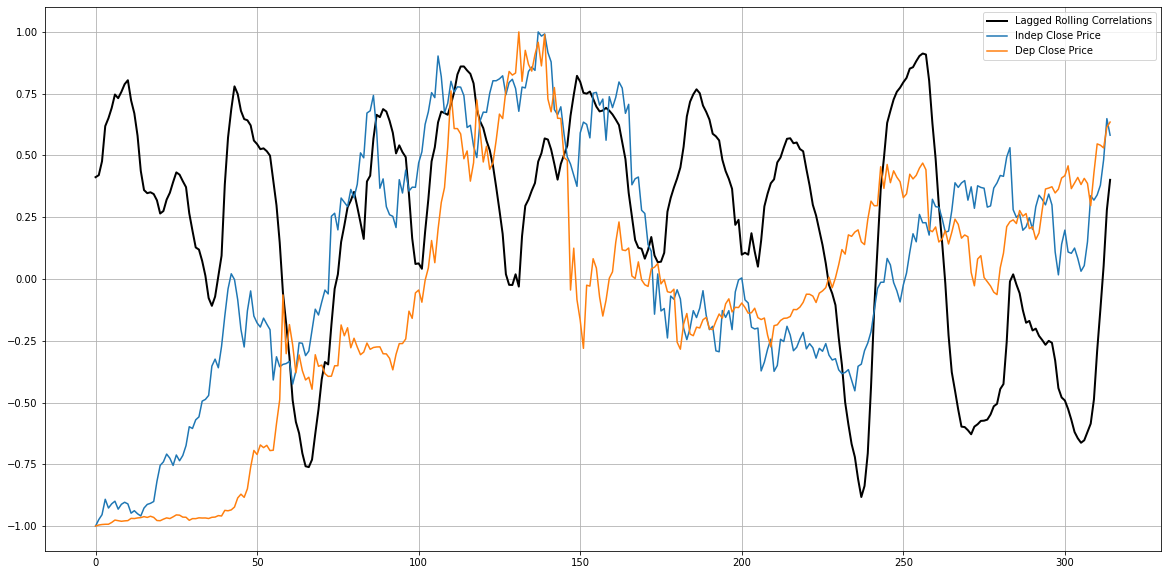

In [22]:
plt.figure(figsize=(20,10))
plt.plot(lag_roll_pears.values, "-k", label="Lagged Rolling Correlations", linewidth=2)
plt.plot(minmax_scale(indep.loc[idx_of_interest].values, (-1, 1)), label="Indep Close Price")
plt.plot(minmax_scale(dep.loc[trading_idx].values, (-1, 1)), label="Dep Close Price")
#plt.plot(dep_volume_scaled, label="Indep Volume")
plt.legend(loc="best")
plt.grid()
plt.show()

## Test Functions

In [23]:
def check_test_res(p):
    if p < 0.05:
        return "Reject NH"
    
    else:
        return "Can't Reject NH"
    
def gen_test_res(test_df, analysis_df):
    test_res = []
    for var_to_test in test_df.columns:

        if "Corr" not in var_to_test:

            if "Close" not in var_to_test:

                _, p_mwu = mannwhitneyu(test_df[var_to_test].values, analysis_df[var_to_test])

                _, p_lev = levene(test_df[var_to_test].values, analysis_df[var_to_test])

                _, p_kw = kruskal(test_df[var_to_test].values, analysis_df[var_to_test])

                test_res.append([var_to_test, p_mwu, check_test_res(p_mwu), p_lev, check_test_res(p_lev), p_kw, check_test_res(p_kw)])

    res_df = pd.DataFrame(test_res)

    columns = ["Market Variable", "Mann Whitney U Pval", "Mann Whitney Res (Means)", "Levene Pval", "Levene Res (Variances)", "Krusal Pval", "Kruskal Res (Medians)"]

    res_df.columns = columns
    
    return res_df

## Test 1: Are there mean, variance or median difference in Returns, Volatility, or Volume during periods of high correlation?
- Step 1: Splice dataframe to obtain subset of variables where correlation > threshold (0.7-0.8)
- Step 2: Select variables of interest
- Step 3: Compares means using T-Test 
- Step 4: Compare medians using Kruskall Wallis Test
- Step 5: Compare variances using Levene's Test

In [24]:
from scipy.stats import mannwhitneyu, levene, kruskal

### Step 1: Filtering the DataFrame based on our hypothesis condition
- In this case this is where thre correlation is greater than a threshold absolute value

In [25]:
control = analysis_df[abs(analysis_df["Correlation"]) <= 0.8]
threshold = 0.8
test1 = analysis_df[abs(analysis_df["Correlation"]) > threshold]
test1

,Independent Close,Independent Returns,Independent 1WkVol,Independent Volume,Dependent Close,Dependent Returns,Dependent 1WkVol,Dependent Volume,Correlation,CorrDiff
2020-12-07,19191.630859,-0.007934,0.027489,26896357742,29.378136,-0.005507,0.028059,238972454,0.804437,1.0
2021-03-19,58346.652344,0.008430,0.042441,49063873786,264.057434,0.008990,0.037879,1873443830,0.827957,1.0
2021-03-20,58313.644531,-0.000566,0.031436,50361731222,264.741669,0.002591,0.032112,2004752539,0.860049,1.0
2021-03-21,57523.421875,-0.013551,0.029719,51943414539,264.886169,0.000546,0.027916,1718563711,0.860253,1.0
2021-03-22,54529.144531,-0.052053,0.028191,56521454974,255.900192,-0.033924,0.027081,2323911466,0.843963,-1.0
2021-03-23,54738.945312,0.003847,0.027158,56435023914,255.689667,-0.000823,0.026514,2010488139,0.830356,-1.0
2021-04-25,49004.253906,-0.020911,0.019709,46117114240,505.077057,0.017449,0.085245,3419309603,0.822209,1.0
2021-07-21,32110.693359,0.077274,0.039091,28203024559,292.531372,0.104799,0.059359,1957623339,-0.809448,-1.0
2021-07-22,32313.105469,0.006304,0.036932,19555230518,293.641144,0.003794,0.058554,1495118544,-0.882311,-1.0
2021-07-23,33581.550781,0.039255,0.038588,22552046192,299.282990,0.019213,0.057665,1849700307,-0.837461,1.0


### Step 2: Selecting variables of interest
- These variables are already self contained within the "analysis_df"

### Step 3, 4, & 5: Mann Whitney U, Levene, Kruskal-Wallis Test to compare means, variances, and medians of distirbutions (assuming non-normality (which is safe for financial time series)

In [26]:
gen_test_res(test1, analysis_df)

,Market Variable,Mann Whitney U Pval,Mann Whitney Res (Means),Levene Pval,Levene Res (Variances),Krusal Pval,Kruskal Res (Medians)
0,Independent Returns,0.747496,Can't Reject NH,0.312715,Can't Reject NH,0.746540,Can't Reject NH
1,Independent 1WkVol,0.015084,Reject NH,0.000729,Reject NH,0.015032,Reject NH
2,Independent Volume,0.041960,Reject NH,0.109789,Can't Reject NH,0.041833,Reject NH
3,Dependent Returns,0.532006,Can't Reject NH,0.070138,Can't Reject NH,0.531177,Can't Reject NH
4,Dependent 1WkVol,0.000220,Reject NH,0.059812,Can't Reject NH,0.000218,Reject NH
5,Dependent Volume,0.314306,Can't Reject NH,0.005889,Reject NH,0.313699,Can't Reject NH


## Test 2: Are there mean, variance or median difference in Returns, Volatility, or Volume during periods owhere correlation is increasing as opposed to decreasing?

### Step 1: Filtering the DataFrame based on our hypothesis condition
- In this case this is where thre correlation is increasing

In [27]:
test2 = analysis_df[analysis_df["CorrDiff"] == 1]
test2

,Independent Close,Independent Returns,Independent 1WkVol,Independent Volume,Dependent Close,Dependent Returns,Dependent 1WkVol,Dependent Volume,Correlation,CorrDiff
2020-11-28,17717.414062,0.035597,0.041522,32601040734,29.143911,0.023484,0.065432,338275296,0.420275,1.0
2020-11-29,18177.484375,0.025967,0.043005,31133957704,30.117603,0.033410,0.066621,347773041,0.476513,1.0
2020-11-30,19625.835938,0.079678,0.052664,47728480399,31.392786,0.042340,0.067284,389608481,0.618783,1.0
2020-12-01,18802.998047,-0.041926,0.054099,49633658712,30.108303,-0.040917,0.056232,467818960,0.651050,1.0
2020-12-02,19201.091797,0.021172,0.053958,37387697139,30.297361,0.006279,0.050322,371441750,0.692536,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-10-03,48199.953125,0.010238,0.045388,26638115879,430.508820,0.005631,0.049543,1470899248,-0.289608,1.0
2021-10-04,49112.902344,0.018941,0.042015,33383173002,425.748901,-0.011056,0.047389,1647171955,-0.122226,1.0
2021-10-05,51514.812500,0.048906,0.036142,35873904236,442.706146,0.039829,0.043124,1526827785,0.053073,1.0
2021-10-06,55361.449219,0.074670,0.037763,49034730168,435.401367,-0.016500,0.037798,2006344571,0.279361,1.0


### Step 2: Selecting variables of interest
- These variables are already self contained within the "analysis_df"

### Step 3, 4, & 5: Mann Whitney U, Levene, Kruskal-Wallis Test to compare means, variances, and medians of distirbutions (assuming non-normality (which is safe for financial time series)

In [28]:
gen_test_res(test2, analysis_df)

,Market Variable,Mann Whitney U Pval,Mann Whitney Res (Means),Levene Pval,Levene Res (Variances),Krusal Pval,Kruskal Res (Medians)
0,Independent Returns,0.080372,Can't Reject NH,0.972408,Can't Reject NH,0.080306,Can't Reject NH
1,Independent 1WkVol,0.942715,Can't Reject NH,0.637036,Can't Reject NH,0.942413,Can't Reject NH
2,Independent Volume,0.803926,Can't Reject NH,0.349517,Can't Reject NH,0.803632,Can't Reject NH
3,Dependent Returns,0.191301,Can't Reject NH,0.260373,Can't Reject NH,0.191171,Can't Reject NH
4,Dependent 1WkVol,0.144614,Can't Reject NH,0.028393,Reject NH,0.144510,Can't Reject NH
5,Dependent Volume,0.336672,Can't Reject NH,0.278092,Can't Reject NH,0.336481,Can't Reject NH


### Plotting the Histograms of variables of interest

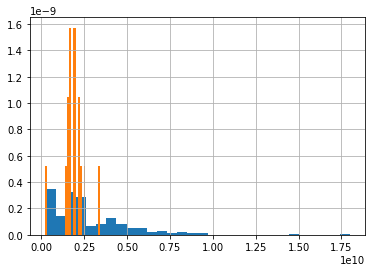

In [29]:
var_to_test = "Dependent Volume"
bins = 30
plt.hist(analysis_df[var_to_test].values, density=True, bins=bins)
plt.hist(test1[var_to_test].values, density=True, bins=bins)
plt.grid()
plt.show()

# Need to build a pipeline to automate this process for all rows in:
- top_dir_lags
- high_corr

In [30]:
# function to generate analysis dataframe

def gen_analysis_df(lag_idx, processed_dataset):
    lags = processed_dataset.iloc[lag_idx]["Lags"] # obtaining lags
    indep = df_close[processed_dataset.iloc[lag_idx]["Independent Var"]] # obtaining independent var name
    dep = df_close[processed_dataset.iloc[lag_idx]["Dependent Var"]] # obtaining dependent var name
    
    lag_roll_pears = lag_roll_corr(indep, dep, lags)
    trading_idx = lag_roll_pears.index
    idx_of_interest = indep[lags-1:-lags].index

    # building a dataframe containing returns, rolling std, and volume of both variables at idx of interest
    # independent variable
    df_indep = Ticker(indep.name).history(period="1y")
    df_indep["Returns"] = df_indep["Close"].pct_change()
    df_indep["1WkVol"] = df_indep["Returns"].rolling(7).std()

    # dependent variable
    df_dep = Ticker(dep.name).history(period="1y")
    df_dep["Returns"] = df_dep["Close"].pct_change()
    df_dep["1WkVol"] = df_dep["Returns"].rolling(7).std()

    df_indep = df_indep[["Close", "Returns", "1WkVol", "Volume"]]
    df_dep = df_dep[["Close", "Returns", "1WkVol", "Volume"]]

    df_indep.columns = ["Independent " + col for col in df_indep.columns]
    df_dep.columns = ["Dependent " + col for col in df_dep.columns]

    analysis_df = pd.concat([df_indep, df_dep], axis=1)

    analysis_df = analysis_df.loc[idx_of_interest]
    lag_roll_pears.index = idx_of_interest

    analysis_df = pd.concat([analysis_df, lag_roll_pears], axis=1)
    analysis_df = analysis_df.rename(columns={0: "Correlation"})
    analysis_df["CorrDiff"] = np.sign(analysis_df["Correlation"].diff())
    analysis_df = analysis_df.dropna()
    
    return analysis_df, indep.name, dep.name, lags

def gen_test_res(test_df, analysis_df):
    test_res = []
    for var_to_test in test_df.columns:

        if "Corr" not in var_to_test:

            if "Close" not in var_to_test:

                _, p_mwu = mannwhitneyu(test_df[var_to_test].values, analysis_df[var_to_test])

                _, p_lev = levene(test_df[var_to_test].values, analysis_df[var_to_test])

                _, p_kw = kruskal(test_df[var_to_test].values, analysis_df[var_to_test])

                test_res.append([var_to_test, p_mwu, check_test_res(p_mwu), p_lev, check_test_res(p_lev), p_kw, check_test_res(p_kw)])

    res_df = pd.DataFrame(test_res)

    columns = ["Market Variable", "Mann Whitney U Pval", "Mann Whitney Res (Means)", "Levene Pval", "Levene Res (Variances)", "Krusal Pval", "Kruskal Res (Medians)"]

    res_df.columns = columns
    
    return res_df

## Apply an automation in order to answer the hypothesis question using entire dataset
### Hypothesis 1: Are BTC and ETH returns statistically unique during periods the correlation is rising?

In [31]:
total_df = pd.DataFrame()

for lag_idx in range(0, len(top_dir_lags)):
    analysis_df, indep_name, dep_name, lags = gen_analysis_df(lag_idx, top_dir_lags)
    test_df = analysis_df[analysis_df["CorrDiff"] == 1] # this is the line to change to change the hypothesis question
    test_res_df = gen_test_res(test_df, analysis_df)
    test_res_df.insert(loc=0, column="Independent Name", value=indep_name)
    test_res_df.insert(loc=1, column="Dependent Name", value=dep_name)
    test_res_df.insert(loc=2, column="Lags", value=lags)
    
    total_df = pd.concat([total_df, test_res_df], axis=0)

In [32]:
total_df.to_excel("Hypothesis 1.xlsx")

In [33]:
indep_ret = total_df[total_df["Market Variable"] == "Independent Returns"]
indep_ret[indep_ret["Mann Whitney Res (Means)"] == "Reject NH"]

# only in 3 cases is this statistically significant

,Independent Name,Dependent Name,Lags,Market Variable,Mann Whitney U Pval,Mann Whitney Res (Means),Levene Pval,Levene Res (Variances),Krusal Pval,Kruskal Res (Medians)
0,BTC-USD,BNB-USD,28,Independent Returns,0.039501,Reject NH,0.720399,Can't Reject NH,0.039466,Reject NH
0,ETH-USD,BNB-USD,22,Independent Returns,0.031230,Reject NH,0.158624,Can't Reject NH,0.031204,Reject NH
0,ETH-USD,LUNA1-USD,24,Independent Returns,0.046229,Reject NH,0.781538,Can't Reject NH,0.046192,Reject NH


### Hypothesis 2: Are BTC and ETH returns statistically unique during periods the correlation is falling?

In [34]:
total_df_2 = pd.DataFrame()

for lag_idx in range(0, len(top_dir_lags)):
    analysis_df, indep_name, dep_name, lags = gen_analysis_df(lag_idx, top_dir_lags)
    test_df = analysis_df[analysis_df["CorrDiff"] == -1] # this is the line to change to change the hypothesis question
    test_res_df = gen_test_res(test_df, analysis_df)
    test_res_df.insert(loc=0, column="Independent Name", value=indep_name)
    test_res_df.insert(loc=1, column="Dependent Name", value=dep_name)
    test_res_df.insert(loc=2, column="Lags", value=lags)
    
    total_df_2 = pd.concat([total_df_2, test_res_df], axis=0)

In [35]:
total_df_2.to_excel("Hypothesis 2.xlsx")

In [36]:
indep_ret = total_df_2[total_df_2["Market Variable"] == "Independent Returns"]
indep_ret[indep_ret["Mann Whitney Res (Means)"] == "Reject NH"]

# only in 4 cases is this statistically significant

,Independent Name,Dependent Name,Lags,Market Variable,Mann Whitney U Pval,Mann Whitney Res (Means),Levene Pval,Levene Res (Variances),Krusal Pval,Kruskal Res (Medians)
0,BTC-USD,BNB-USD,28,Independent Returns,0.046667,Reject NH,0.395033,Can't Reject NH,0.046627,Reject NH
0,ETH-USD,BNB-USD,27,Independent Returns,0.042568,Reject NH,0.998964,Can't Reject NH,0.042530,Reject NH
0,ETH-USD,BNB-USD,22,Independent Returns,0.027224,Reject NH,0.506239,Can't Reject NH,0.027200,Reject NH
0,ETH-USD,LUNA1-USD,24,Independent Returns,0.028812,Reject NH,0.806409,Can't Reject NH,0.028785,Reject NH


### Hypothesis/Question 3: For variables with a large % of high lagged correlations (abs()>0.7), what is going on with the market variables? 

In [37]:
total_df_3 = pd.DataFrame()

for lag_idx in range(0, len(high_corr)):
    analysis_df, indep_name, dep_name, lags = gen_analysis_df(lag_idx, high_corr)
    test_df = analysis_df[abs(analysis_df["Correlation"]) >= 0.7] # this is the line to change to change the hypothesis question
    test_res_df = gen_test_res(test_df, analysis_df)
    test_res_df.insert(loc=0, column="Independent Name", value=indep_name)
    test_res_df.insert(loc=1, column="Dependent Name", value=dep_name)
    test_res_df.insert(loc=2, column="Lags", value=lags)
    
    total_df_3 = pd.concat([total_df_3, test_res_df], axis=0)

In [38]:
indep_ret = total_df_3[total_df_3["Market Variable"] == "Independent Returns"]
indep_ret[indep_ret["Mann Whitney Res (Means)"] == "Reject NH"]

,Independent Name,Dependent Name,Lags,Market Variable,Mann Whitney U Pval,Mann Whitney Res (Means),Levene Pval,Levene Res (Variances),Krusal Pval,Kruskal Res (Medians)
0,BTC-USD,AVAX-USD,6,Independent Returns,0.010559,Reject NH,0.526850,Can't Reject NH,0.010547,Reject NH
0,ETH-USD,DOT1-USD,6,Independent Returns,0.016919,Reject NH,0.143169,Can't Reject NH,0.016898,Reject NH


In [39]:
vol = total_df_3[(total_df_3["Market Variable"] == "Dependent 1WkVol") | (total_df_3["Market Variable"] == "Independent 1WkVol")]
vol[vol["Mann Whitney Res (Means)"] == "Reject NH"]

,Independent Name,Dependent Name,Lags,Market Variable,Mann Whitney U Pval,Mann Whitney Res (Means),Levene Pval,Levene Res (Variances),Krusal Pval,Kruskal Res (Medians)
4,BTC-USD,AVAX-USD,20,Dependent 1WkVol,0.000005,Reject NH,0.829421,Can't Reject NH,0.000005,Reject NH
1,BTC-USD,LUNA1-USD,8,Independent 1WkVol,0.009273,Reject NH,0.803306,Can't Reject NH,0.009263,Reject NH
4,BTC-USD,LUNA1-USD,8,Dependent 1WkVol,0.046538,Reject NH,0.158591,Can't Reject NH,0.046495,Reject NH
4,ETH-USD,CELO-USD,20,Dependent 1WkVol,0.026086,Reject NH,0.031038,Reject NH,0.026057,Reject NH
4,BTC-USD,SOL1-USD,5,Dependent 1WkVol,0.037675,Reject NH,0.128712,Can't Reject NH,0.037639,Reject NH
...,...,...,...,...,...,...,...,...,...,...
1,ETH-USD,ALGO-USD,6,Independent 1WkVol,0.019403,Reject NH,0.224628,Can't Reject NH,0.019378,Reject NH
4,ETH-USD,ALGO-USD,8,Dependent 1WkVol,0.016578,Reject NH,0.034052,Reject NH,0.016555,Reject NH
1,BTC-USD,USDT-USD,5,Independent 1WkVol,0.024536,Reject NH,0.036037,Reject NH,0.024504,Reject NH
4,ETH-USD,USDT-USD,10,Dependent 1WkVol,0.019572,Reject NH,0.083075,Can't Reject NH,0.019533,Reject NH


In [40]:
total_df_3[total_df_3["Mann Whitney Res (Means)"] == "Reject NH"]

,Independent Name,Dependent Name,Lags,Market Variable,Mann Whitney U Pval,Mann Whitney Res (Means),Levene Pval,Levene Res (Variances),Krusal Pval,Kruskal Res (Medians)
4,BTC-USD,AVAX-USD,20,Dependent 1WkVol,0.000005,Reject NH,0.829421,Can't Reject NH,0.000005,Reject NH
5,BTC-USD,AVAX-USD,20,Dependent Volume,0.000524,Reject NH,0.003026,Reject NH,0.000524,Reject NH
1,BTC-USD,LUNA1-USD,8,Independent 1WkVol,0.009273,Reject NH,0.803306,Can't Reject NH,0.009263,Reject NH
4,BTC-USD,LUNA1-USD,8,Dependent 1WkVol,0.046538,Reject NH,0.158591,Can't Reject NH,0.046495,Reject NH
4,ETH-USD,CELO-USD,20,Dependent 1WkVol,0.026086,Reject NH,0.031038,Reject NH,0.026057,Reject NH
...,...,...,...,...,...,...,...,...,...,...
4,ETH-USD,USDT-USD,10,Dependent 1WkVol,0.019572,Reject NH,0.083075,Can't Reject NH,0.019533,Reject NH
5,ETH-USD,USDT-USD,10,Dependent Volume,0.000094,Reject NH,0.000300,Reject NH,0.000094,Reject NH
2,BTC-USD,USDT-USD,10,Independent Volume,0.000056,Reject NH,0.574118,Can't Reject NH,0.000055,Reject NH
4,BTC-USD,USDT-USD,10,Dependent 1WkVol,0.021153,Reject NH,0.695026,Can't Reject NH,0.021108,Reject NH


In [41]:
total_df_3.to_excel("Hypothesis 3.xlsx")

In [42]:
assert(False)

AssertionError: 

### Other Hypotheses/Questions
- What are market variables doing when correlation < 0 
- What are market variables doing during periods of low/no correlation -0.2 to 0.2?


In [44]:
from mp2 import process
from multiprocessing import Pool
from functools import partial
import os

# offset lags: 1 to 30
# rolling lags: 2 to 30
offset = np.arange(2, 30, 1)
rolling = np.arange(3, 30, 1)
inputs = [[df_close, indep, dep, o, r, 0.7] for r in rolling for o in offset for indep in df_close.columns for dep in df_close.columns] # inputs into a multiprocessing function

data = [[indep, dep, o, r, 0.7] for r in rolling for o in offset for indep in df_close.columns for dep in df_close.columns] # inputs into a multiprocessing function

In [45]:
import time

# initialising the pool
pool = Pool(os.cpu_count())

start = time.time()
output = pool.starmap(process, inputs)
end = time.time()

# terminating the pool
pool.close()

print(end - start)

565.0315873622894


In [46]:
for i, l in enumerate(data):
    l.extend(output[i])

In [ ]:
database = pd.DataFrame(data)

In [54]:
database

,0,1,2,3,4,5,6,7
0,BTC-USD,BTC-USD,2,3,0.7,72,0.490305,0.566298
1,BTC-USD,ETH-USD,2,3,0.7,70,0.518006,0.535912
2,BTC-USD,DOGE-USD,2,3,0.7,3,0.581717,0.560773
3,BTC-USD,XRP-USD,2,3,0.7,5,0.559557,0.566298
4,BTC-USD,SOL1-USD,2,3,0.7,27,0.515235,0.563536
...,...,...,...,...,...,...,...,...
635791,WAVES-USD,BCH-USD,29,29,0.7,28684,0.558442,0.155340
635792,WAVES-USD,COTI-USD,29,29,0.7,99,0.600649,0.181230
635793,WAVES-USD,CELO-USD,29,29,0.7,51,0.587662,0.122977
635794,WAVES-USD,HBAR-USD,29,29,0.7,94,0.594156,0.242718


In [55]:
database.columns = ["Independent Variable", "Dependent Variable", "Offset Lag", "Rolling Lag", "Threshold", "Periodicity", "Directional Accuracy", "High Correlation Percentage"]

In [56]:
database.to_csv("Lagged Rolling Correlation Dataset.csv")

In [23]:
start = time.time()

o = []
for i in inputs[:100000]:
    o.append(process(i[0], i[1], i[2], i[3], i[4], i[5]))
    
end = time.time()
    
print(end - start)  

408.9355499744415


# Immediate Next Steps:
- Continue to come up with hypotheses based on:
    - the processed dataframes: how else can generate data of interest with additional EXPERIMENTS 
    - Running the same tests using the "high_corr" matrix (done)
    - Buying market data from GlassNode and coming up with new creative hypotheses

In [ ]:
total_df_3

# Major Research Expansionary Ideas
- Modify lag_roll_pears to include an offset lag between the two time series and a general rolling lag:
    - offset the time series at different lags and explore the various rolling lags at those offsets
    - you will need to update how the idx_of_interest is calculated 
        
- Try every combination of independent and dependent variable (HUGE)
- Consider removing periodicity filter and running the entire process

# Misc

# Fitting 2 Sinewaves to data?

In [ ]:
import numpy, scipy.optimize
import pylab as plt
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])
    guess = np.append(guess, guess)

    def doublesinfunc(t, A, w, p, c, A2, w2, p2, c2):  return (A * numpy.sin(w*t + p) + c) + (A2 * numpy.sin(w2*t + p2) + c2)
    popt, pcov = scipy.optimize.curve_fit(doublesinfunc, tt, yy, p0=guess)
    A, w, p, c, A2, w2, p2, c2 = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: (A * numpy.sin(w*t + p) + c) + (A2 * numpy.sin(w2*t + p2) + c2)
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

tt = np.arange(0, len(lag_roll_pears), 1)
yy = lag_roll_pears
res = fit_sin(tt, yy)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(tt, yy, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

## Attempting to Analyse Power Spectral Density of Lagged Correlations (looking for harmonic frequencies - recurring correlation patterns)

- Plot Autocorrelation
- Plot normalised power spectral density

In [ ]:
autocorr = []

for i in range(1, 160):
    shifted = lag_roll_pears.shift(i).dropna()
    autocorr.append(np.corrcoef(shifted, lag_roll_pears[-len(shifted):])[0][1])
    
plot_acf(lag_roll_pears, lags=30)
plt.show()

In [ ]:
f = fft((np.array(lag_roll_pears)))
frq = f*np.conj(f)
norm_frq = np.abs(frq)/np.max(np.abs(frq))

plt.figure(figsize=(16, 8))
plt.stem(norm_frq[:50])
plt.grid()

In [ ]:
ACF = acf(lag_roll_pears) # ACF
PSD = fft(ACF) # PSD

In [ ]:
plt.stem(ACF)
plt.show()
plt.stem(np.abs(PSD))
plt.show()

In [ ]:
q = np.abs(PSD[0:13])
p = np.abs(PSD[13:])
x = np.arange(-len(PSD)/2 , len(PSD)/2  , 1)
plt.stem(x, np.append(p, q))
plt.grid()